In [1]:
import numpy as np
import sunode
import sunode.wrappers.as_pytensor
import pymc as pm
import pandas as pd
from sirpy.models.SIR import SIR
import arviz as az

In [2]:
# See if jax is using the gpu
import jax
print(jax.devices())


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


[CpuDevice(id=0)]


In [3]:
data = pd.read_csv("covid_japan_processed.csv", parse_dates=[0], index_col=0)
t = (data.index - data.index.min()) / (data.index.max() - data.index.min())
train = data.iloc[0:100,:]
test = data.iloc[100::,:]
print(f"Train is the first {len(train)} days and test is remaining {len(test)} days.") #Typo

Train is the first 100 days and test is remaining 23 days.


In [4]:
# TODO: ADD BOUNDS FOR TRAINING INITIAL CONDITIONS
easy_sir = SIR(
  name="My sir",
  hyper_params={
    "time_space": (0, 1),
    "time_range": t.to_numpy()[0:len(train)],
  },
  train_params={
    "beta": 0.5,
    "gamma": 0.1,
  },
  static_params={
      "initial_condition": np.array([0.75, 0.01, 0.24]),
  }
)
easy_sir.train_data = train.to_numpy()
easy_sir.test_data = test.to_numpy()
easy_sir

Model: My sir
States: ['S', 'I', 'R']
Transitions: ['$\\beta SI$', '$\\gamma I$']
Has train data? True
Has test data? True
Trained? False

In [5]:
a = lambda t, y, p: - p.beta * y.S  * y.I
b = lambda t, y, p: p.beta * y.S  * y.I - p.gamma * y.I
c = lambda t, y, p: p.gamma * y.S
dic = {
    "S": a,
    "I": b,
    "R": c,
}
dk = lambda t, y, p: {k: v(t, y, p) for k,v in zip(dic.keys(), dic.values())}

In [6]:
with pm.Model() as sir_m:
    # Define priors
    beta = pm.Uniform("beta", 0, 1)
    gamma = pm.Uniform("gamma", 0, 1)
    sd = pm.HalfNormal('sd')

    # Solve the ODE
    y_hat, _, problem, solver, _, _ = sunode.wrappers.as_pytensor.solve_ivp(
        y0={
	    # The initial conditions of the ode. Each variable
	    # needs to specify a PyTensor or numpy variable and a shape.
	    # This dict can be nested.
            'S': (pm.HalfNormal('S0', sigma=0.5), ()),
            'I': (pm.HalfNormal('I0', sigma=0.5), ()),
            'R': (pm.HalfNormal('R0', sigma=0.5), ()),
        },
        params={
	    # Each parameter of the ode. sunode will only compute derivatives
	    # with respect to PyTensor variables. The shape needs to be specified
	    # as well. It it infered automatically for numpy variables.
	    # This dict can be nested.
            'beta': (beta, ()),
            'gamma': (gamma, ()),
            'extra': np.zeros(1),
        },
	# A functions that computes the right-hand-side of the ode using
	# sympy variables.
        rhs=dk,
	# The time points where we want to access the solution
        tvals=easy_sir.p("time_range"),
        t0=easy_sir.p("time_range")[0],
    )
    # We can access the individual variables of the solution using the
    # variable names.
    pm.Deterministic('S_mu', y_hat['S'])
    pm.Deterministic('I_mu', y_hat['I'])
    pm.Deterministic('R_mu', y_hat['R'])



    # likehoods
    # posterior prop prior x likehood
    # prior x likehood --> MCMC --> frecuencias relativas
    # Si suficiente tiempo la cadena de markov converge y representa las verdaderas frecuencais
    pm.Lognormal('S', mu=y_hat["S"], sigma=sd, observed=easy_sir.train_data[:,0])
    pm.Lognormal('I', mu=y_hat["I"], sigma=sd, observed=easy_sir.train_data[:,1])
    pm.Lognormal('R', mu=y_hat["R"], sigma=sd, observed=easy_sir.train_data[:,2])


In [7]:
%%time
with sir_m:
    # Inference
    trace = pm.sample(cores=2, chains=2,  progressbar=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, gamma, sd, S0, I0, R0]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 386 seconds.


CPU times: user 22.8 s, sys: 1.25 s, total: 24.1 s
Wall time: 6min 35s


<AxesSubplot: >

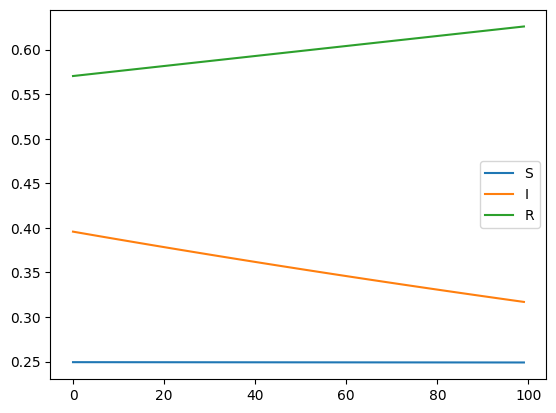

In [8]:
# get the values of y_hat['S']

pd.DataFrame([
    sir_m['S_mu'].eval(),
    sir_m['I_mu'].eval(),
    sir_m['R_mu'].eval()
],
    index=['S', 'I', 'R']
).T.plot()





array([[<AxesSubplot: title={'center': 'beta'}>,
        <AxesSubplot: title={'center': 'beta'}>],
       [<AxesSubplot: title={'center': 'gamma'}>,
        <AxesSubplot: title={'center': 'gamma'}>],
       [<AxesSubplot: title={'center': 'sd'}>,
        <AxesSubplot: title={'center': 'sd'}>],
       [<AxesSubplot: title={'center': 'S0'}>,
        <AxesSubplot: title={'center': 'S0'}>],
       [<AxesSubplot: title={'center': 'I0'}>,
        <AxesSubplot: title={'center': 'I0'}>],
       [<AxesSubplot: title={'center': 'R0'}>,
        <AxesSubplot: title={'center': 'R0'}>],
       [<AxesSubplot: title={'center': 'S_mu'}>,
        <AxesSubplot: title={'center': 'S_mu'}>],
       [<AxesSubplot: title={'center': 'I_mu'}>,
        <AxesSubplot: title={'center': 'I_mu'}>],
       [<AxesSubplot: title={'center': 'R_mu'}>,
        <AxesSubplot: title={'center': 'R_mu'}>]], dtype=object)

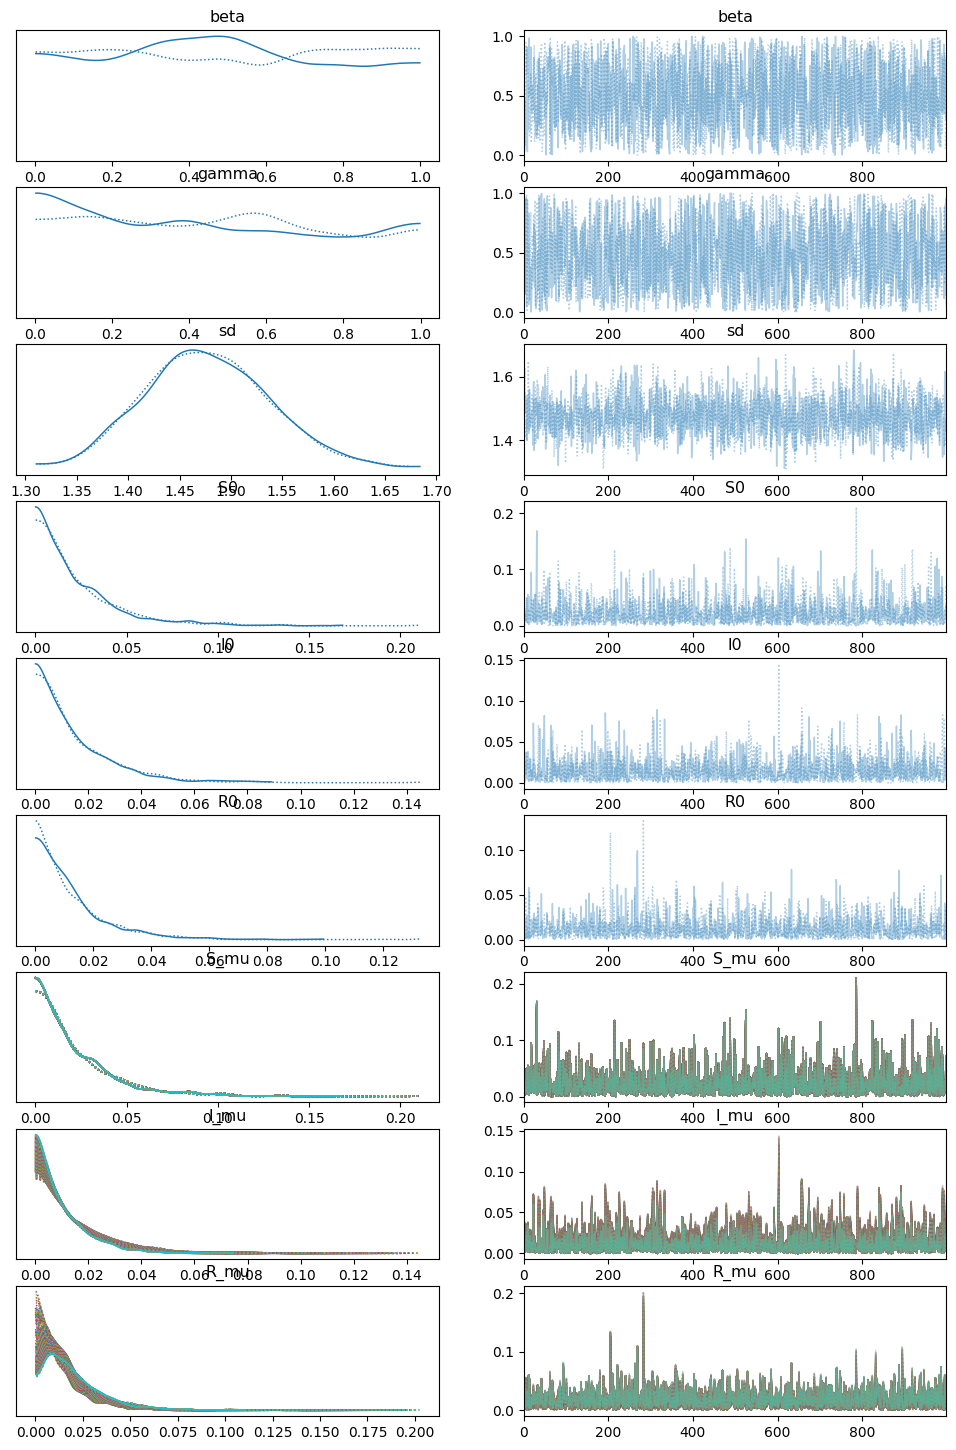

In [9]:
az.plot_trace(trace)

/home/gustavo_santelices/anaconda3/envs/sirpy/lib/python3.8/site-packages/arviz/plots/plot_utils.py:271: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (306) in plot_posterior, generating only 40 plots
  warnings.warn(


array([[<AxesSubplot: title={'center': 'beta'}>,
        <AxesSubplot: title={'center': 'gamma'}>,
        <AxesSubplot: title={'center': 'sd'}>,
        <AxesSubplot: title={'center': 'S0'}>],
       [<AxesSubplot: title={'center': 'I0'}>,
        <AxesSubplot: title={'center': 'R0'}>,
        <AxesSubplot: title={'center': 'S_mu\n0'}>,
        <AxesSubplot: title={'center': 'S_mu\n1'}>],
       [<AxesSubplot: title={'center': 'S_mu\n2'}>,
        <AxesSubplot: title={'center': 'S_mu\n3'}>,
        <AxesSubplot: title={'center': 'S_mu\n4'}>,
        <AxesSubplot: title={'center': 'S_mu\n5'}>],
       [<AxesSubplot: title={'center': 'S_mu\n6'}>,
        <AxesSubplot: title={'center': 'S_mu\n7'}>,
        <AxesSubplot: title={'center': 'S_mu\n8'}>,
        <AxesSubplot: title={'center': 'S_mu\n9'}>],
       [<AxesSubplot: title={'center': 'S_mu\n10'}>,
        <AxesSubplot: title={'center': 'S_mu\n11'}>,
        <AxesSubplot: title={'center': 'S_mu\n12'}>,
        <AxesSubplot: title={'

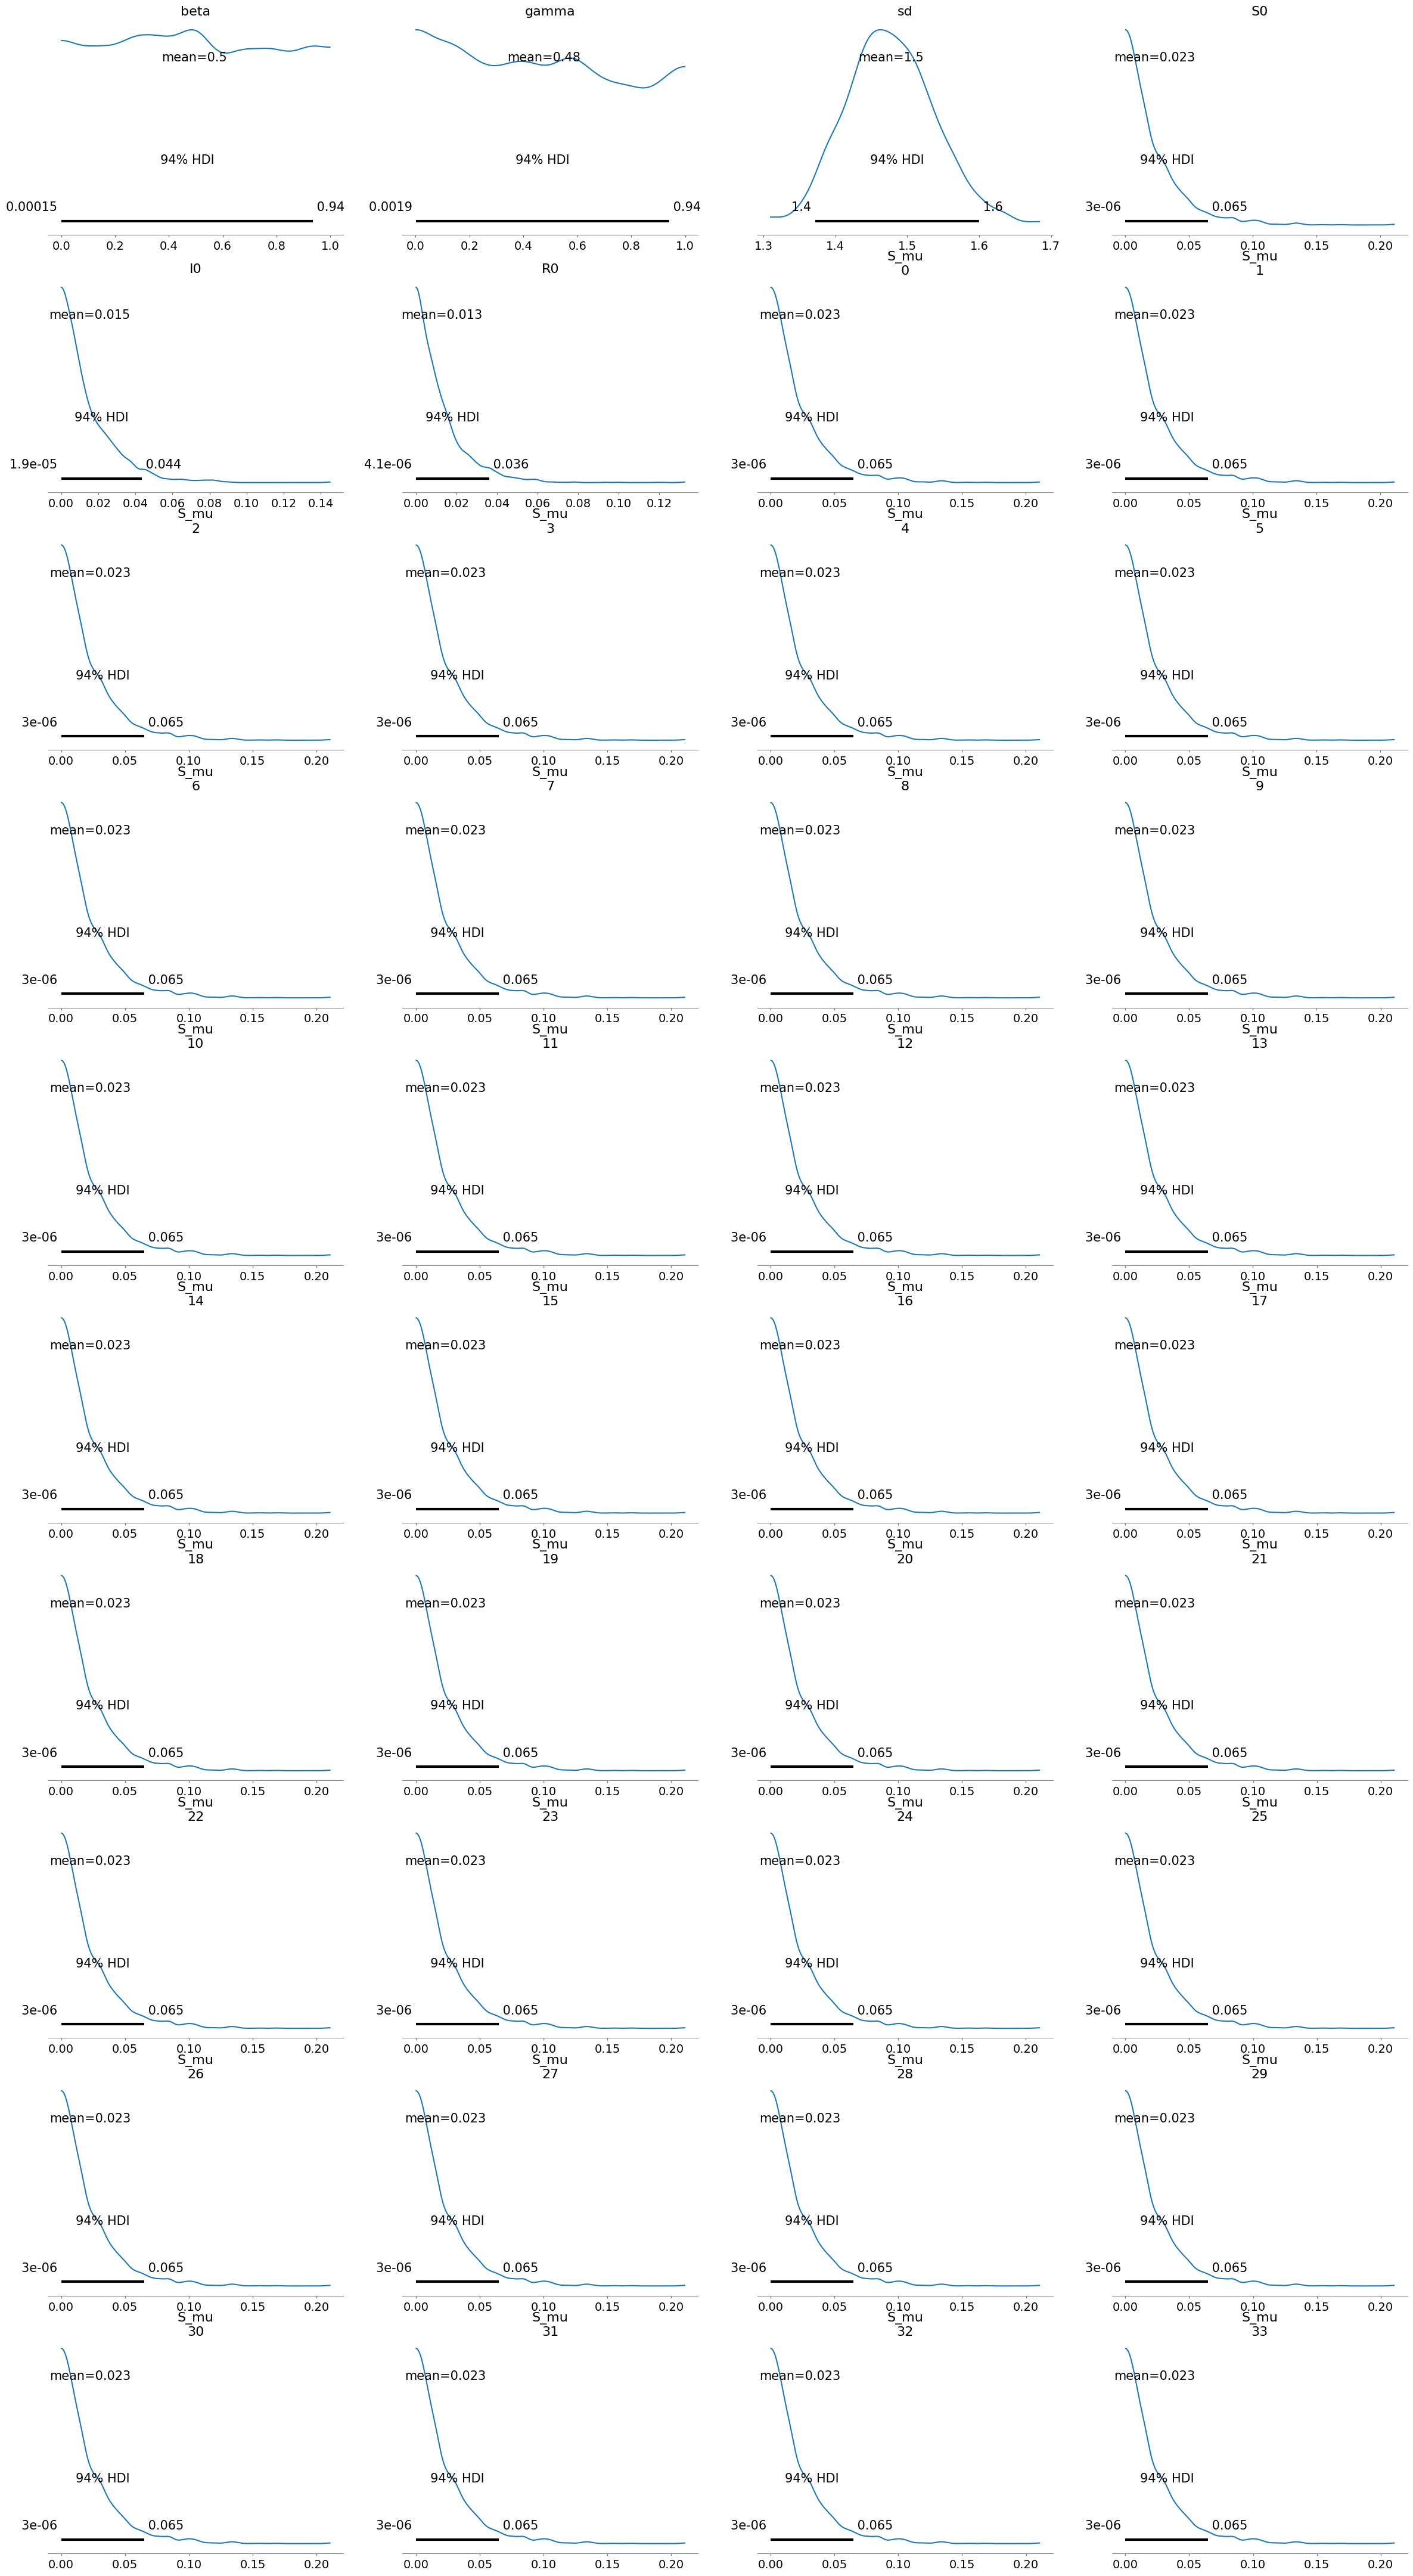

In [10]:
# plot the posterior with arviz
az.plot_posterior(trace)
